## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal 
import glob
import sys
sys.path.append('../')
from model.lda import LDAHandler

## Data Loading

In [2]:
def load_bci_data(path: str) -> pd.DataFrame:
    df = pd.read_csv(path, skiprows=4)

    # Select and Rename Necessary Channels
    df = df[[' EXG Channel 0', ' EXG Channel 1', ' EXG Channel 2', ' Timestamp']]
    df.columns = ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2', 'Timestamp']

    return df

## Filtering and Epoching

In [3]:
def filter_signals(df: pd.DataFrame, channels: list) -> pd.DataFrame:
    b = signal.firwin(numtaps=51, cutoff=[0.25 , 25], pass_zero='bandpass', fs=250)
    a = 1
    # We will not edit the DataFrame in place.
    result = df.copy()
    for channel in channels:
        # DC Offset Correction:
        result[channel] = result[channel] - result[channel].mean()
        # Signal Drift Removal:
        result[channel] = signal.detrend(result[channel])
        result[channel] = signal.filtfilt(b, a, result[channel], padlen=len(df) - 1)
    return result

def epoch_signals(df: pd.DataFrame) -> pd.DataFrame:
    # We will not edit the DataFrame in place.
    result = df.copy()
    result['Epoch'] = result['Timestamp'] // 7.5
    epochs = result['Epoch'].unique()
    result = result[result['Epoch'] > epochs.max() - 40]
    epochs = result['Epoch'].unique()
    result['Epoch'] = result['Epoch'] - epochs.min()
    return result



## Signal Parts Extraction

In [4]:
def extract_baseline_signal(df: pd.DataFrame) -> pd.DataFrame:
    result = df.reset_index(drop=True)
    end = result['Timestamp'][0] + 4
    return result[result['Timestamp'] < end]

def extract_direction_signal(df: pd.DataFrame) -> pd.DataFrame:
    result = df.reset_index(drop=True)
    end = result['Timestamp'][0] + 6
    return result[(result['Timestamp'] > end - 2) & (result['Timestamp'] < end)]

def windowed_mean(data: np.array, n_windows: int) -> np.array:
    chunks = np.array_split(data, n_windows)
    return np.array([np.mean(c) for c in chunks])

## Processing Loop for all Files

c:\Users\Scott\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Scott\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Scott\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Scott\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\Users\Scott\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3419: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Scott\AppData\Local\P

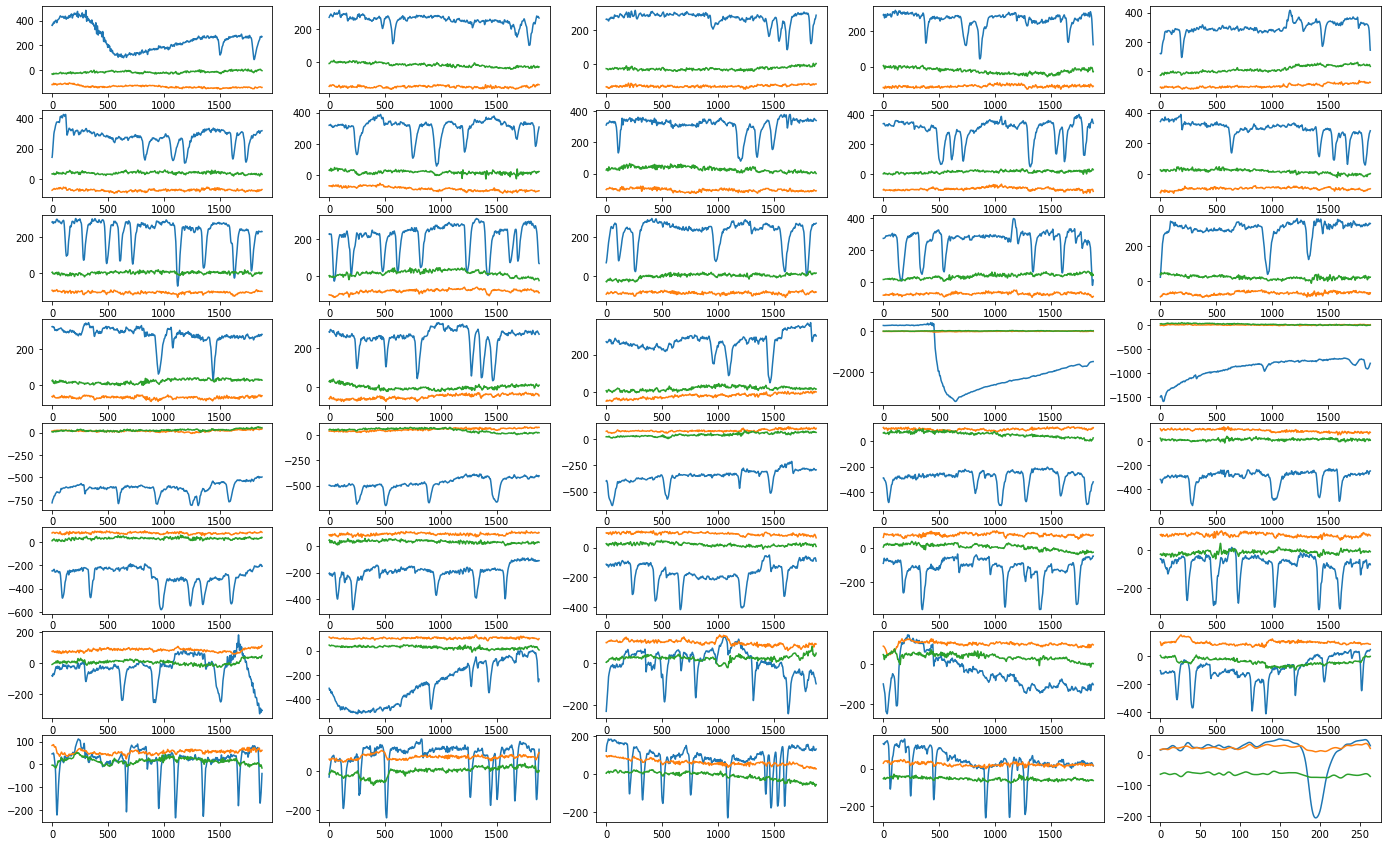

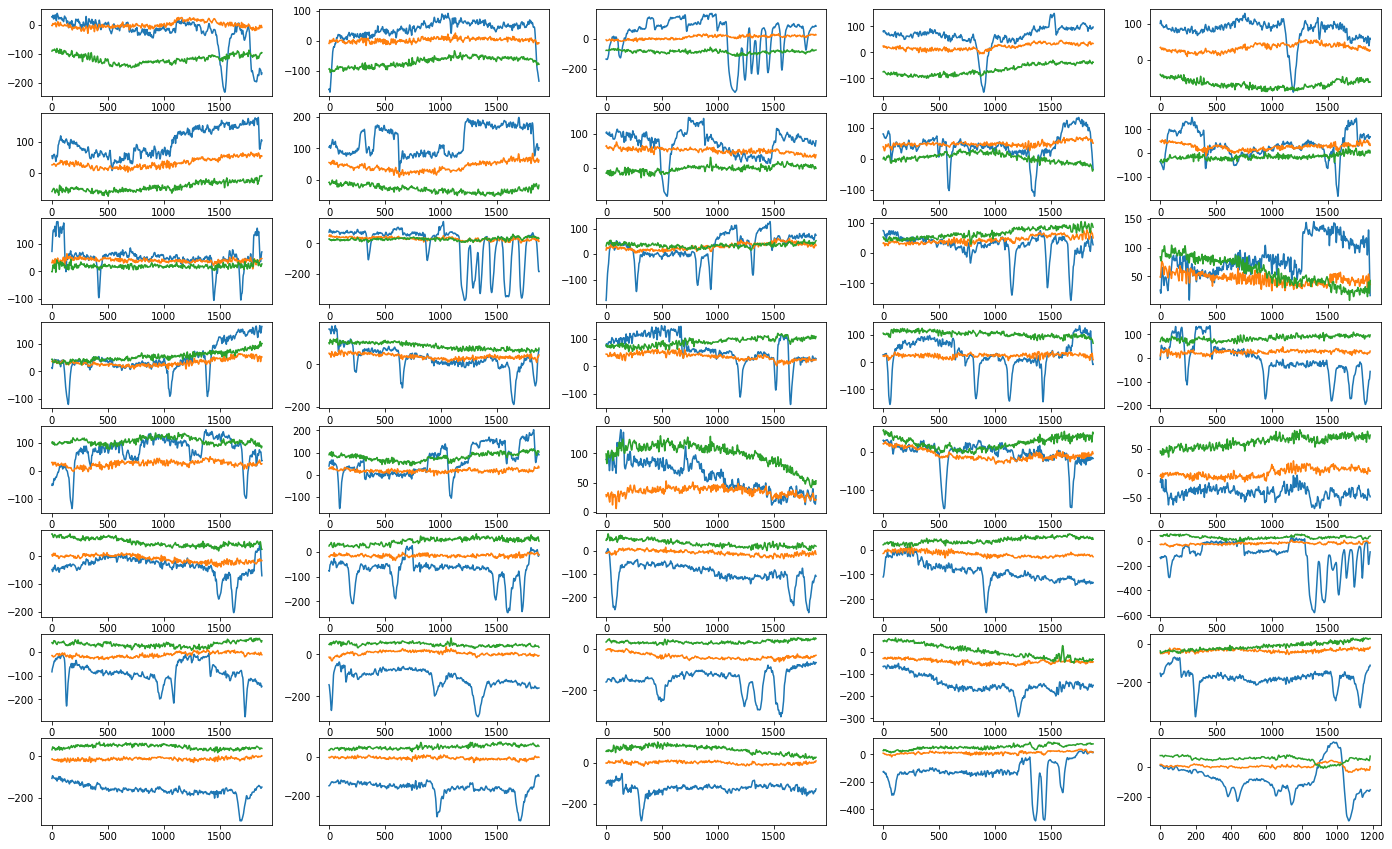

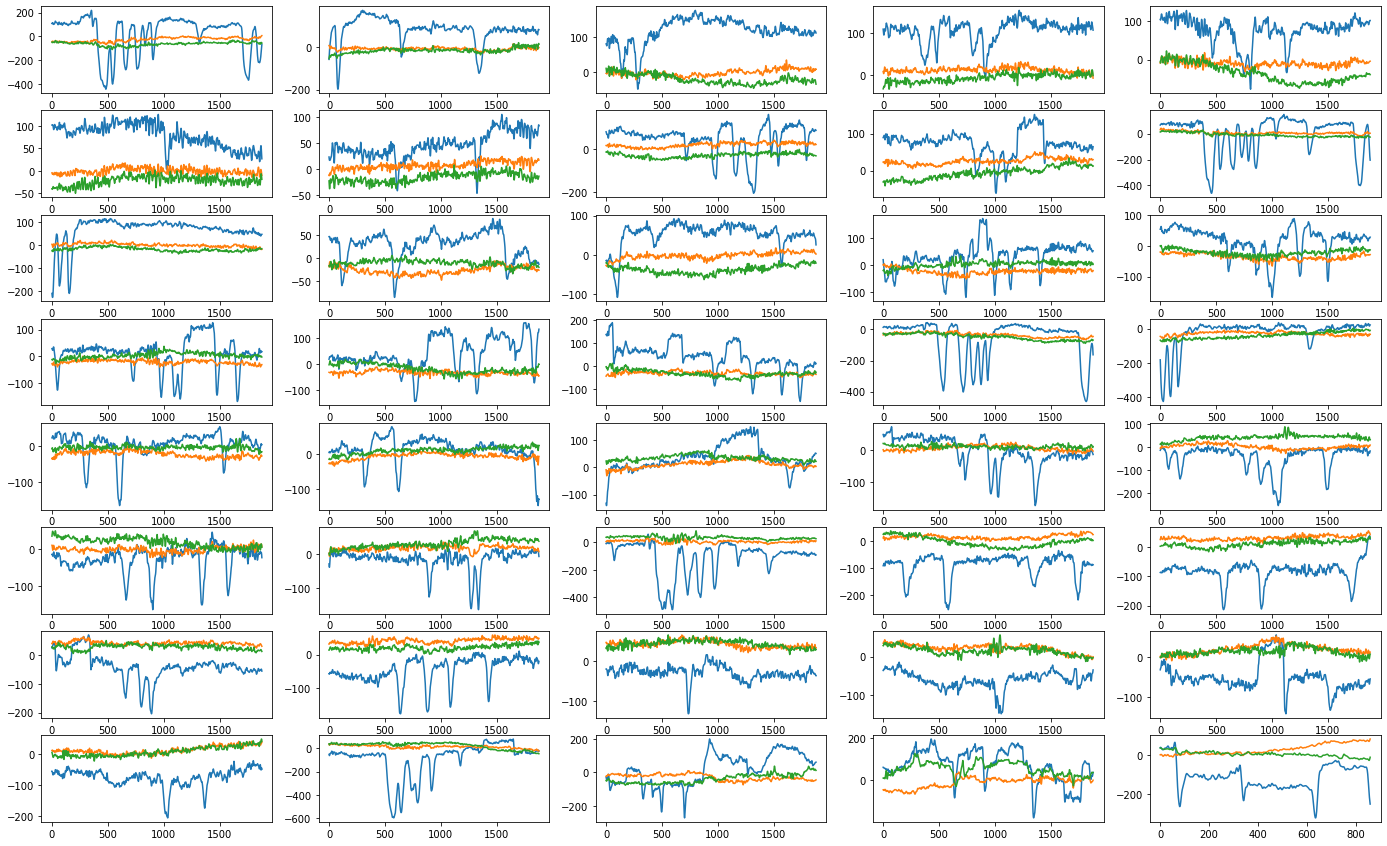

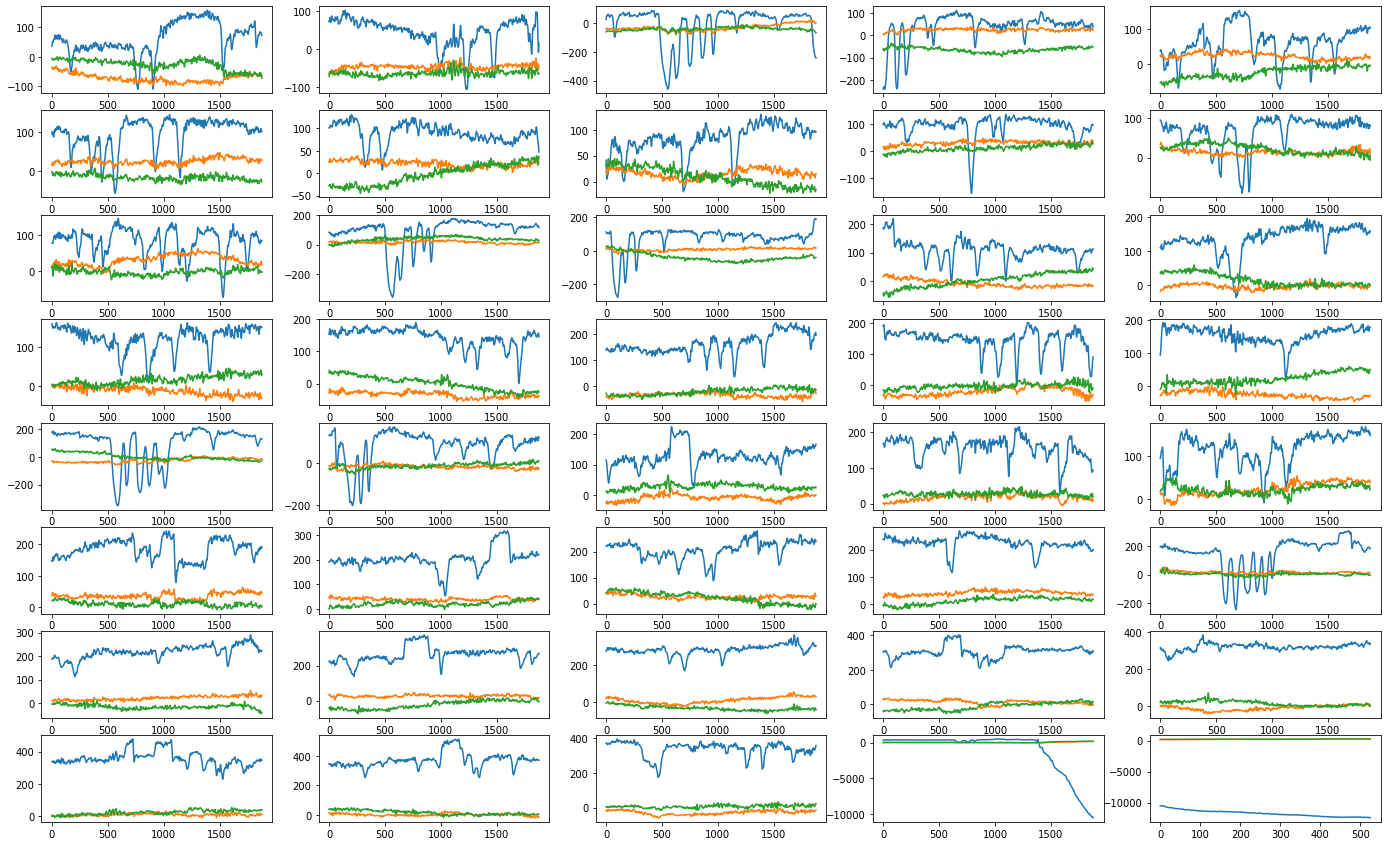

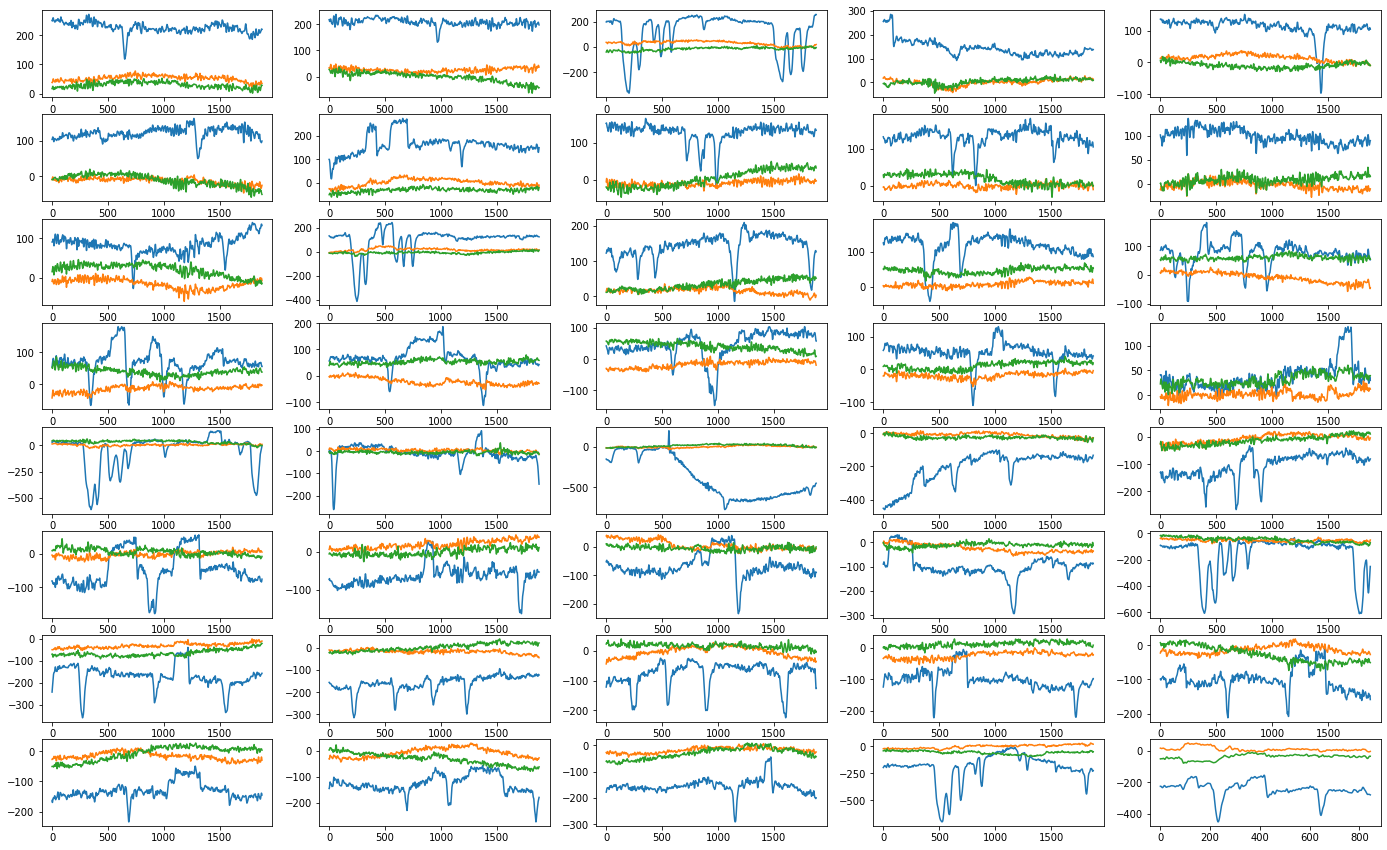

In [5]:
# Find our raw files
data_files = glob.glob("../data/raw/*.txt")
signal_channels = ['EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2']

X, y = [], ([0, 1, 0, 1, 1, 0, 0, 1] * 5) * 5

for i, file in enumerate(data_files):
    # Load data from raw files
    df = load_bci_data(file)
    
    # Apply relevant filters
    filtered_df = filter_signals(df, signal_channels)

    # Calculate Epochs
    filtered_df = epoch_signals(filtered_df)

    # 'Center' Timestamps
    filtered_df['Timestamp'] = filtered_df['Timestamp'] - filtered_df['Timestamp'].min()

    # Save images of epoch data
    fig, ax = plt.subplots(8, 5, figsize=(24, 15))
    ax_shape = ax.shape
    ax = ax.flatten()
    for j, a in enumerate(ax):
        at_epoch = filtered_df[filtered_df['Epoch'] == j].reset_index(drop=True)
        a.plot(at_epoch['EXG Channel 0']);
        a.plot(at_epoch['EXG Channel 1']);
        a.plot(at_epoch['EXG Channel 2']);
    ax.reshape(ax_shape)
    fig.savefig(f'example_epochs_{i + 1}.png');

    # Extract baseline and direction signal
    for epoch in filtered_df['Epoch'].unique():
        epoch_data = filtered_df[filtered_df['Epoch'] == epoch]

        baseline_signal = extract_baseline_signal(epoch_data)
        direction_signal = extract_direction_signal(epoch_data)

        # Baseline correction
        # for channel in signal_channels:
        #     direction_signal[channel] = direction_signal[channel] - baseline_signal[channel].mean()
        
        direction_signal_data = direction_signal[signal_channels].to_numpy().flatten()

        # Perform a windowed mean to standardize shape
        direction_signal_data = windowed_mean(direction_signal_data, 1500)

        X.append(direction_signal_data)

X = np.array(X)
y = np.array(y)
removed_index = ~np.isnan(X).any(axis=1)
X = X[removed_index, :]
y = y[removed_index]

## Writing numpy data to files

In [6]:
np.save('../data/processed/X.npy', X)
np.save('../data/processed/y.npy', y)